# **Instrument to Instrument (ITI) translation: Solar Orbiter/EUI/FSI-to-SDO/AIA**

## Read The Docs
For more information about the tool and background of the individual case studies see:

[iti-documentation.rtfd.io](https://iti-documentation.readthedocs.io/en/latest/)

The Instrument-to-Instrument (ITI) translation tool can perform image domain translations between two different instruments. This allows ITI to be used for image enhancement, instrument intercalibration, and super-resolution observations in different scientific fields. For heliophysics, ITI has been applied to several instruments of various space-based and ground-based solar telescopes.

This colab notebook provides an example of translation for the image enhancement case study by applying ITI for translation between the **Solar Orbiter/EUI/FSI** instrument and **SDO/AIA**.
The Full Sun Imager onboard Solar Orbiter provides observations in the two wavelength channels `174` and `304` Å with an angular resolution of 10 arcsec. In comparison, the AIA instrument is equipped to observe in 10 wavelength channels with a spatial resolution of 1.5 arcsec. Due to the strong elliptical orbit of Solar Orbiter, intercalibration between the two instruments can provide joint data products for combined multi-viewpoint studies.

For more details about the instruments, see: https://github.com/spaceml-org/helio_tools/wiki/

Colab offers free online computation power. The runtime type can be changed to speed up the translations (*Runtime -> Change runtime type -> Hardware accelerator -> GPU*). Custom observations can be enhanced by replacing the download URLs or uploading your own files.

## Installation

In [ ]:
!pip install git+https://github.com/spaceml-org/InstrumentToInstrument.git@development
!pip install lightning
!pip install sunpy_soar
!pip install sunpy

  Cloning https://github.com/Schirni/InstrumentToInstrument.git (to revision development) to /tmp/pip-req-build-5fte8max
  Running command git clone --filter=blob:none --quiet https://github.com/Schirni/InstrumentToInstrument.git /tmp/pip-req-build-5fte8max
  Running command git checkout -b development --track origin/development
  Switched to a new branch 'development'
  Branch 'development' set up to track remote branch 'development' from 'origin'.
  Resolved https://github.com/Schirni/InstrumentToInstrument.git to commit 4a5c6864e3cff638c0f86677a67b31ba652ccd8d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 48.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64

### Imports

In [ ]:
from iti.evaluation.util import *
import glob
from iti.download.download_solo import SOLODownloader
from iti.download.download_sdo import SDODownloader
from iti.data.editor import solo_norm
from iti.translate import *
from iti.data.dataset import get_intersecting_files
from datetime import timedelta, datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable

/usr/local/lib/python3.10/dist-packages/google/cloud/storage/transfer_manager.py:30: UserWarning: The module `transfer_manager` is a preview feature. Functionality and API may change. This warning will be removed in a future release.
  warnings.warn(


## Download data

### Testset

We provide a publicly available dataset which allows the users to play around with a subset of the data available without downloading the entire database.

This dataset contains ``.fits`` files from **PROBA2/SWAP**, **SDO/AIA**, **Solar Orbiter/EUI (FSI and HRI)**, **SOHO/EIT** and **STEREO/EUVI**.

In addition 3 trained models are stored with:
1. PROBA2/SWAP to SDO/AIA
2. Solar Orbiter/EUI FSI to SDO/AIA and
3. SDO/AIA to Solar Orbiter/EUI HRI

to perform the translation.  


In [ ]:
!gsutil cp -r gs://iti-dataset/ '/content/'

Copying gs://iti-dataset/configs/proba2_to_sdo_colab.yaml...
Copying gs://iti-dataset/models/aia_to_hri_v0_1.pt...
- [2 files][ 58.1 MiB/ 58.1 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://iti-dataset/models/fsi_to_aia_v0_3.pt...
Copying gs://iti-dataset/models/swap_to_aia_v0_4.pt...
Copying gs://iti-dataset/proba2/174/2021-11-11T00:00:00.fits...
Copying gs://iti-dataset/proba2/174/2021-11-11T12:00:00.fits...
Copying gs://iti-dataset/proba2/174/2021-11-14T00:00:00.fits...
Copying gs://iti-dataset/proba2/174/2021-11-15T00:00:00.fits...
Copying gs://iti-dataset/proba2/174/2021-11-16T00:00:00.fits...
Copying gs://iti-dataset/sdo/171/2021-11-11T00:00:00.fits...
Copying gs://iti-dataset/sdo/171/2021-11-11T12:00:00.fits...
C

### Instrument specific downloaders

If you wish to translate different time periods that are not included in the test dataset, we provide download routines for the instruments used for ITI.

To download data from SDO, we use the [JSOC](http://jsoc.stanford.edu/) website. You must register with your email address to download the data.

In [ ]:
solo_downloader = SOLODownloader(base_path='fsi')
solo_downloader.downloadDate(date=datetime(2022, 6, 15, 15), FSI=True)

In [ ]:
sdo_downloader = SDODownloader(base_path='sdo', email='chri.schirni@hotmail.de')
sdo_downloader.downloadDate(date=datetime(2022, 6, 15, 15))

In [ ]:
fsi_files = get_intersecting_files('/content/fsi', ['eui-fsi174-image', 'eui-fsi304-image'])

In [ ]:
fsi_files = get_intersecting_files('/content/iti-dataset/solo', ['eui-fsi174-image', 'eui-fsi304-image'])
aia_files = get_intersecting_files('/content/iti-dataset/sdo', [171, 304])

## Pre-processing

For visual comparison after translation, we load the ``.fits`` files as sunpy maps including a crop to 1.1 solar radii. For SDO/AIA observations the loading also includes a correction for instrument degradation.

### FSI pre-processing
- Load ``.fits`` as SunPy map
- Crop to 1.1 solar radii

In [ ]:
fsi_data_174 = [getFSIdata(f) for f in tqdm(fsi_files[0])]
fsi_data_304 = [getFSIdata(f) for f in tqdm(fsi_files[1])]

100%|██████████| 5/5 [01:26<00:00, 17.27s/it]


### AIA pre-processing

- Load ``.fits`` as SunPy Map
- Apply degradation correction
- Crop to 1.1 solar radii


In [ ]:
aia_data_171 = [getAIAdata(f, resolution=1024) for f in tqdm(aia_files[0])]
aia_data_304 = [getAIAdata(f, resolution=1024) for f in tqdm(aia_files[1])]

100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


## Translation

The translator classes are the core element of the ITI translation. They follow the notation: ``InstrumentAToInstrumentB``. We initialize the translation class by giving it the path where the model is stored.

In [ ]:
translator = SolarOrbiterToSDO(model_name='/content/iti-dataset/models/fsi_to_aia_v0_3.pt')

The result of the ITI translation is a SunPy map that stores all necessary coordinate information.

For multiple wavelengths the transalation of all channels is performed simultaneously.

In [ ]:
iti_maps = translate(fsi_files, translator)

## Visualize

We can compare the original **Solar Orbiter FSI** observation with the ground truth **AIA** and our translated **ITI** image.

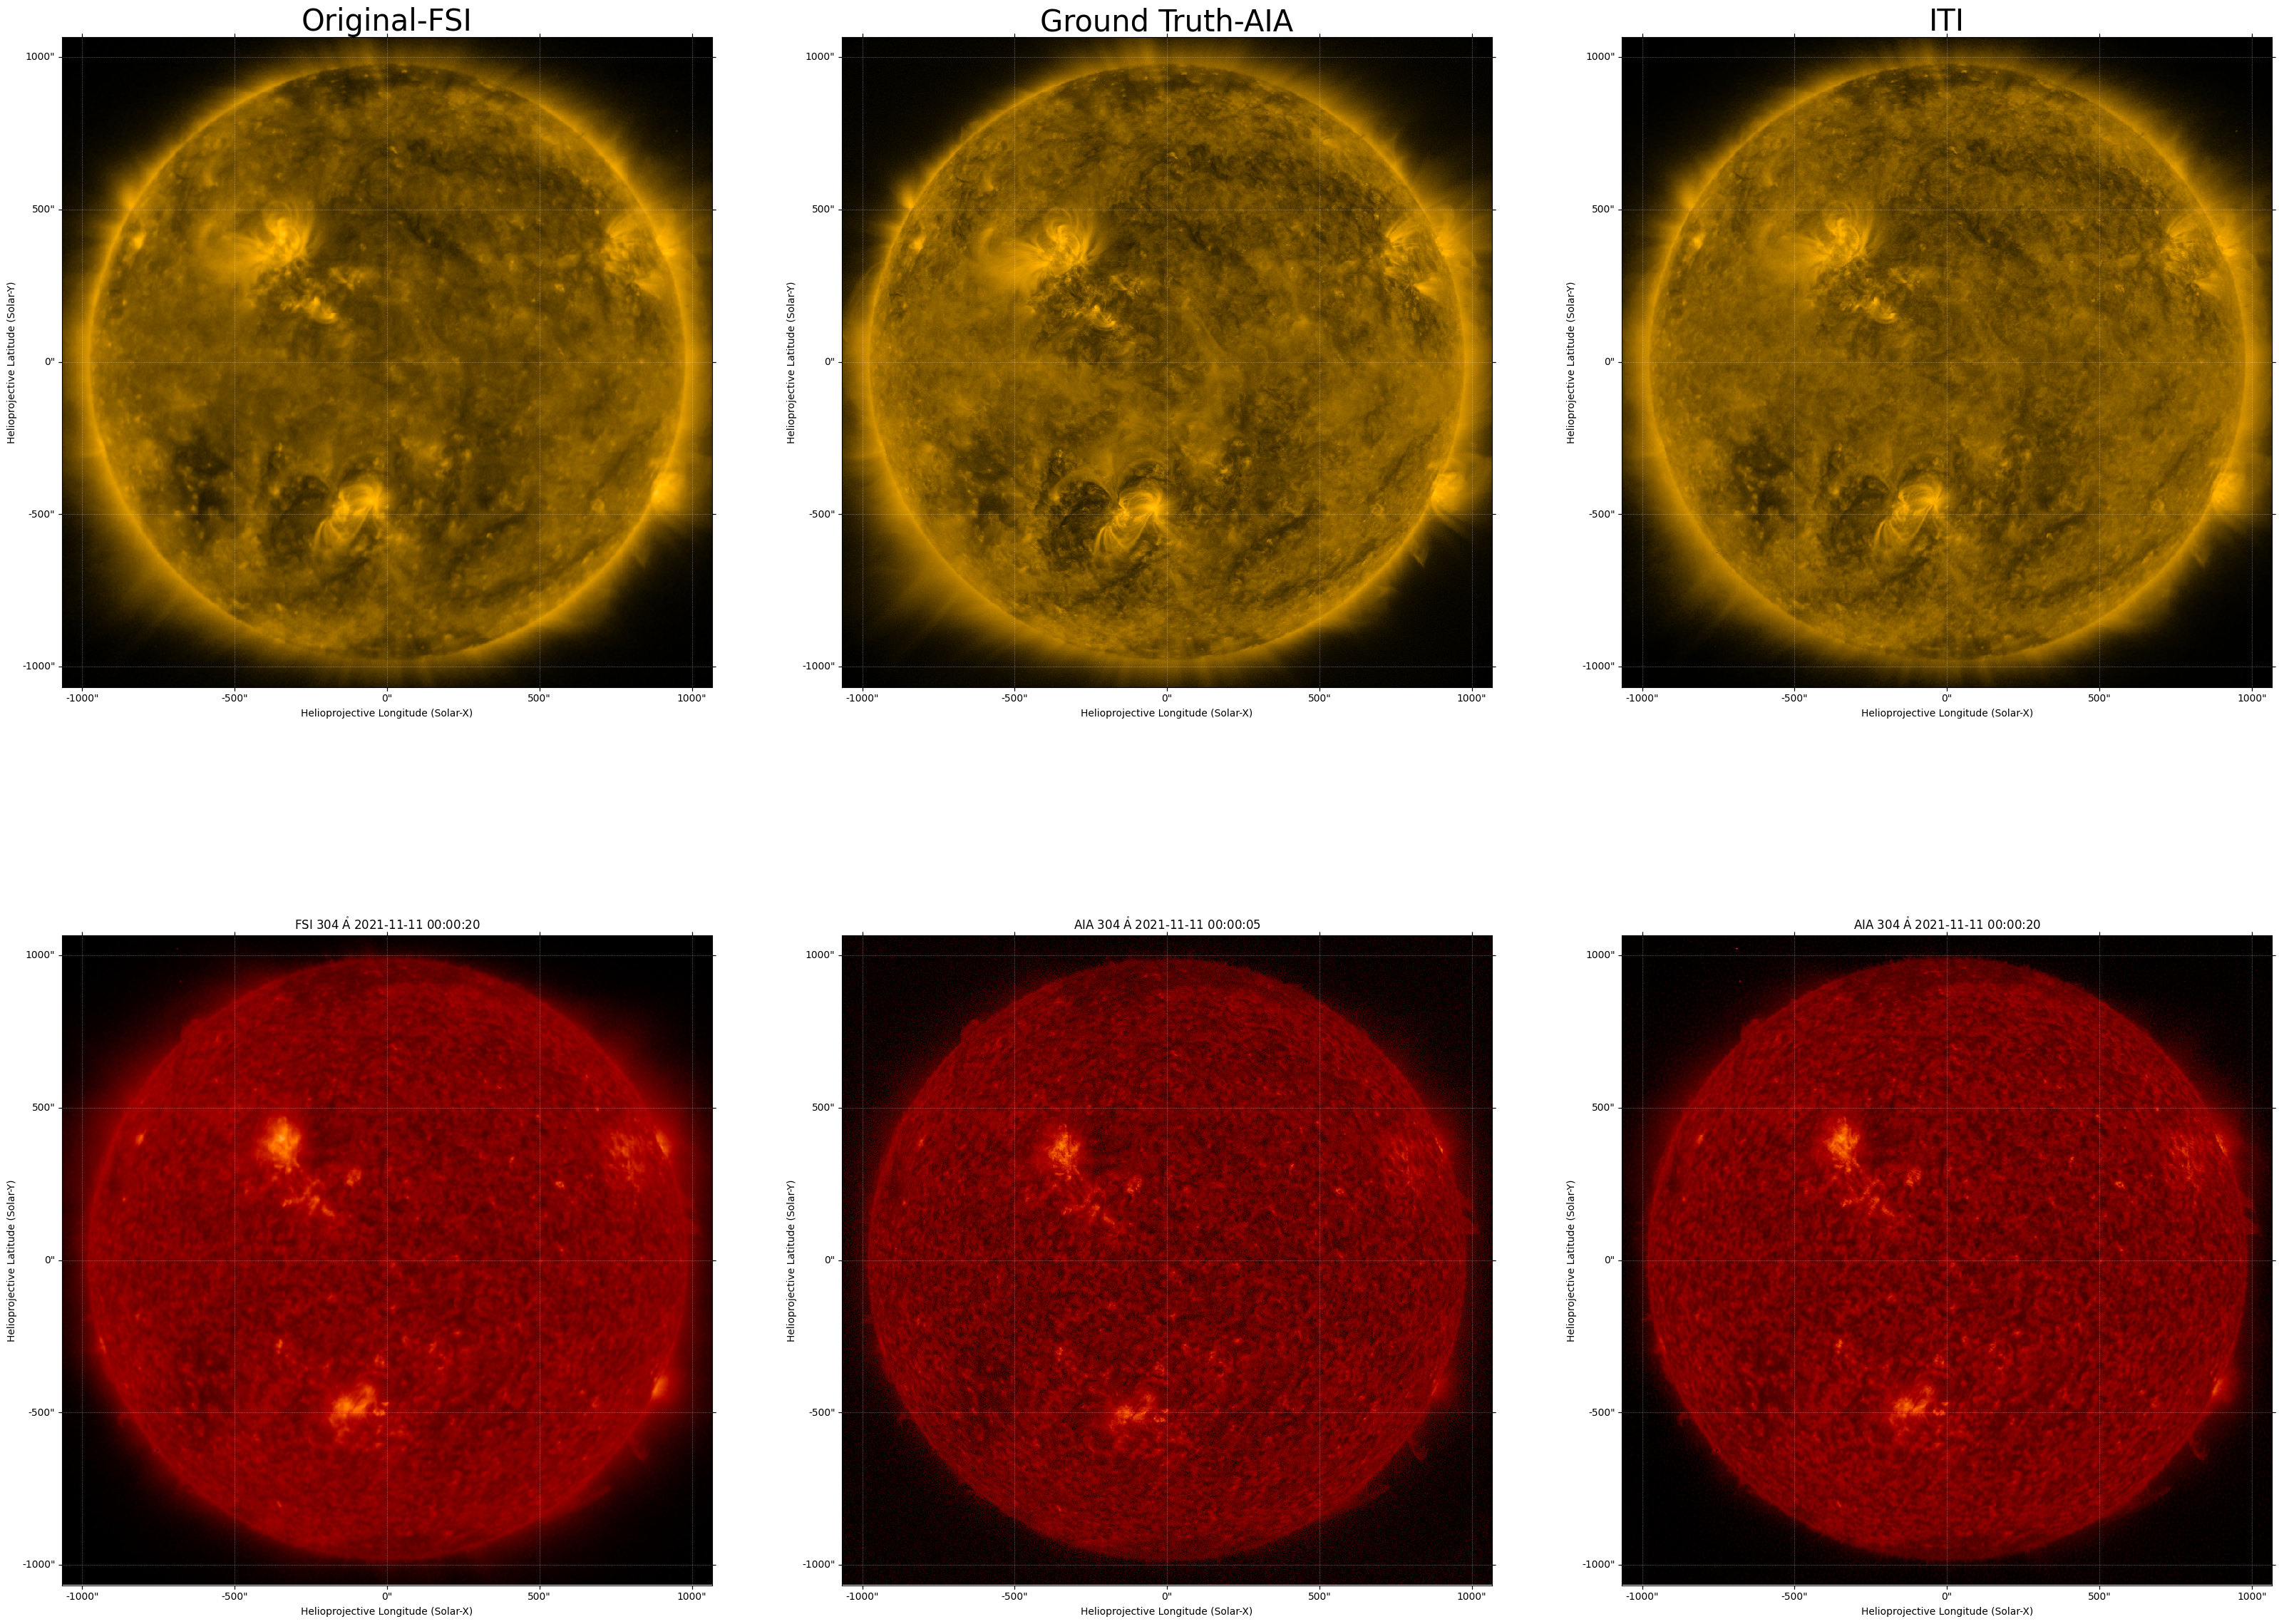

In [ ]:
fig, axs = plt.subplots(2, 3, subplot_kw={'projection': aia_data_171[0]}, figsize=(40, 30), dpi=100)
fsi_data_174[0].plot(axes=axs[0, 0], norm=solo_norm['eui-fsi174-image'])
aia_data_171[0].plot(axes=axs[0, 1], norm=sdo_norms[171])
iti_maps[0][0].plot(axes=axs[0, 2], norm=sdo_norms[171])
fsi_data_304[0].plot(axes=axs[1, 0], norm=solo_norm['eui-fsi304-image'])
aia_data_304[0].plot(axes=axs[1, 1], norm=sdo_norms[304])
iti_maps[0][1].plot(axes=axs[1, 2], norm=sdo_norms[304])
axs[0, 0].set_title('Original-FSI', fontsize=30)
axs[0, 1].set_title('Ground Truth-AIA', fontsize=30)
axs[0, 2].set_title('ITI', fontsize=30)
plt.show()

## Evaluation

In oder to test if ITI is able to intercalibrate FSI to AIA observation we use the [Frechet Inception Distance (FID)](https://arxiv.org/pdf/1706.08500) quality metric. This compares the image distributions of the instruments. Because Solar Orbiter has a strong elliptical orbit, the observations even in the Sun-Earth line are shifted to SDO/AIA observations and therefore pixel-based metrics cannot be used.

The FID is calculated for the **baseline** and **ITI**. The baseline corresponds to the distribution comaprison between the original FSI observation and the ground truth AIA. For ITI we calculate the FID between the interclaibrated ITI observation and AIA.
The FID is calculate across the test set, which is independent from the training and validation set.

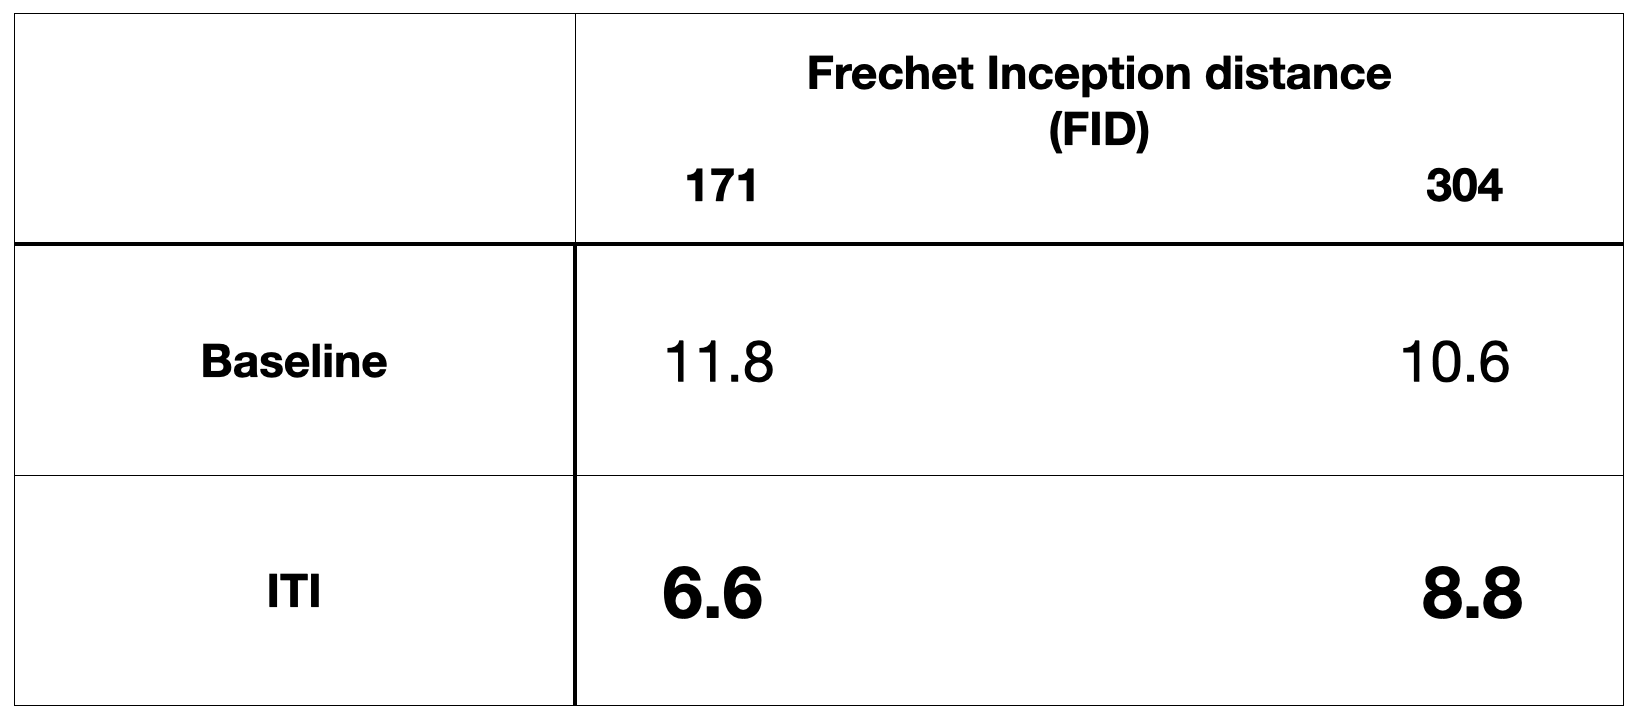

## Contact Information

For any questions and feedback please contact: christoph.schirninger@uni-graz.at

If you encounter any problems regarding the notebook or the code, you can raise an issue on [GitHub](https://github.com/spaceml-org/InstrumentToInstrument)